In [1]:
import time

import os
import json
import random
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import joblib

# ML/DL
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import cv2

In [3]:
#pip install "numpy<2" --force-reinstall


In [5]:
#pip install opencv-contrib-python


In [7]:
tab_df=pd.read_csv("simulated_mine_6000_realistic_unbiased.csv")


In [9]:
WINDOW=3
HORIZON =3
SEED=42


In [11]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED) 

In [13]:
def train_lightgbm(df, reserve=20):
    #print('[TRAIN][LightGBM] Training tabular baseline...')

    train_parts = []
    forecast_parts = []

    # Reserve last `reserve` timesteps per station
    for sid, g in df.groupby("station_id"):
        g_sorted = g.sort_values("timestamp").reset_index(drop=True)
        if len(g_sorted) > reserve:
            train_parts.append(g_sorted.iloc[:-reserve])
            forecast_parts.append(g_sorted.iloc[-reserve:])
        else:
            # if not enough timesteps, skip forecasting
            train_parts.append(g_sorted)

    train_df = pd.concat(train_parts).reset_index(drop=True)
    forecast_df = pd.concat(forecast_parts).reset_index(drop=True)

    X = train_df[['rainfall_mm', 'disp_inc_mm', 'strain_inc_micro',
                  'pore_kpa', 'vibration', 'disp_rate_6h',
                  'strain_6h', 'pore_6h', 'vib_6h', 'cumulative_disp_mm']]
    y = train_df['rockfall_event']

    dtrain = lgb.Dataset(X, label=y)
    params = {'objective': 'binary', 'metric': 'auc', 'is_unbalance': True, 'learning_rate': 0.05}
    bst = lgb.train(params, dtrain, num_boost_round=120)

    joblib.dump(bst, os.path.join(MODEL_DIR, 'lightgbm_tabular.pkl'))
    #print('[TRAIN][LightGBM] Finished training baseline.')

    return bst, train_df, forecast_df


In [15]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x


In [17]:
class TransformerClassifier(nn.Module):
    def __init__(self, in_feats, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_lin = nn.Linear(in_feats, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos = PositionalEncoding(d_model)
        self.fc = nn.Sequential(nn.Linear(d_model, 32), nn.ReLU(), nn.Dropout(0.2), nn.Linear(32, 1), nn.Sigmoid())
    def forward(self, x):
        # x: (batch, seq_len, in_feats)
        x = self.input_lin(x)
        x = self.pos(x)
        x = self.encoder(x)
        # take last token
        out = x[:, -1, :]
        return self.fc(out).squeeze()


In [19]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
def prepare_sequences(df, window=WINDOW, horizon=HORIZON):
    #print('[SEQ] Preparing sequence windows (Transformer)')

    Xs, ys = [], []
    df = df.sort_values(['station_id', 'timestamp']).reset_index(drop=True)

    for sid, g in df.groupby('station_id'):
        arr = g[['rainfall_mm', 'disp_inc_mm', 'strain_inc_micro',
                 'pore_kpa', 'vibration']].values
        labels = g['rockfall_event'].values

        # Sliding windows for training
        for i in range(len(arr) - window - horizon):
            x_win = arr[i:i + window]
            label = labels[i + window + horizon - 1]
            Xs.append(x_win)
            ys.append(label)

    # Convert to arrays
    X = np.array(Xs)
    y = np.array(ys)

    # ---- scale features ----
    n_samples, seq_len, n_feats = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, n_feats))
    Xs_scaled = scaler.transform(X.reshape(-1, n_feats)).reshape(n_samples, seq_len, n_feats)
    joblib.dump(scaler, os.path.join(MODEL_DIR, 'seq_scaler.pkl'))

    #print('[SEQ] windows:', Xs_scaled.shape, 'labels:', np.bincount(y))
    return Xs_scaled, y


In [24]:
def train_transformer(X, y, epochs=6):
    #print('[TRAIN][Transformer] Training sequence model...')

    # --- Train/validation split ---
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    train_ds = SeqDataset(X_train, y_train)
    val_ds = SeqDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128)

    # --- Device setup ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- Init transformer ---
    model = TransformerClassifier(in_feats=X.shape[-1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    bce = nn.BCELoss()

    # --- Training loop ---
    for epoch in range(1, epochs + 1):
        model.train()
        tloss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = bce(preds, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)

        tloss /= len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        ys, yps = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yp = model(xb).cpu().numpy()
                yps.extend(yp.tolist())
                ys.extend(yb.numpy().tolist())

        auc = roc_auc_score(ys, yps) if len(set(ys)) > 1 else 0.5
        # print(f'Epoch {epoch} loss={tloss:.4f} val_auc={auc:.4f}')

    # --- Save trained model ---
    torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'transformer_seq.pt'))
    # print('[TRAIN][Transformer] saved model')

    return model


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [29]:
device

device(type='cpu')

In [31]:
def build_fusion_dataset(df, transformer=None, lgb_model=None):
    #print('[FUSE] Building fusion dataset')

    # Tabular features
    X_tab = df[['rainfall_mm', 'disp_inc_mm', 'strain_inc_micro',
                'pore_kpa', 'vibration', 'disp_rate_6h',
                'strain_6h', 'pore_6h', 'vib_6h', 'cumulative_disp_mm']].values
    y = df['rockfall_event'].values if 'rockfall_event' in df else None

    # Load scaler from prepare_sequences
    scaler = joblib.load(os.path.join(MODEL_DIR, 'seq_scaler.pkl'))

    # Transformer embedding
    if transformer is None:
        transformer = TransformerClassifier(in_feats=5)
        transformer.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'transformer_seq.pt'), map_location=device))
        transformer.eval()
        transformer.to(device)

    seq_feats = []
    df = df.sort_values(['station_id', 'timestamp']).reset_index(drop=True)

    for sid, g in df.groupby('station_id'):
        arr = g[['rainfall_mm', 'disp_inc_mm', 'strain_inc_micro', 'pore_kpa', 'vibration']].values
        arr_scaled = scaler.transform(arr)
        seq_tensor = torch.tensor(arr_scaled, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            x = transformer.input_lin(seq_tensor)
            x = transformer.pos(x)
            x = transformer.encoder(x)
            emb_seq = x.squeeze(0).cpu().numpy()
        seq_feats.append(emb_seq)

    seq_feats = np.vstack(seq_feats)

    # Add LightGBM predictions
    if lgb_model is not None:
        from sklearn.preprocessing import MinMaxScaler
        lgbm_preds = lgb_model.predict(X_tab).reshape(-1, 1)
        lgbm_preds_norm = MinMaxScaler().fit_transform(lgbm_preds)
        X_fuse = np.hstack([X_tab, seq_feats, lgbm_preds_norm])
        #print('[FUSE] Added LightGBM predictions')
    else:
        X_fuse = np.hstack([X_tab, seq_feats])

    #print('[FUSE] X_fuse shape:', X_fuse.shape)
    return X_fuse, y


In [33]:
def train_fusion_model(X_fuse_train, y_train):
   # print('[TRAIN][FUSION] Training meta-learner (LogisticRegression)...')

    # Split training set into train/val for model evaluation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_fuse_train, y_train,
        test_size=0.2,
        random_state=SEED,
        stratify=y_train
    )

    # Initialize meta-learner
    clf = LogisticRegression(max_iter=500)

    # Train on training part
    clf.fit(X_tr, y_tr)

    # --- Validation performance ---
    yprob = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, yprob)
    #print('[TRAIN][FUSION] Validation ROC AUC:', round(auc, 4))

    # Save trained meta model
    joblib.dump(clf, os.path.join(MODEL_DIR, 'meta_fusion.pkl'))
    #print('[TRAIN][FUSION] Saved meta_fusion.pkl')

    return clf


In [35]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [37]:
import folium
from folium.plugins import HeatMap

[LightGBM] [Info] Number of positive: 206, number of negative: 5594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 5800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035517 -> initscore=-3.301574
[LightGBM] [Info] Start training from score -3.301574


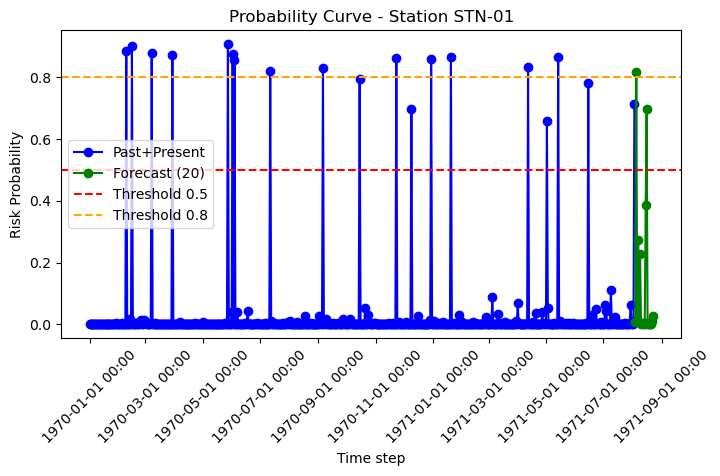

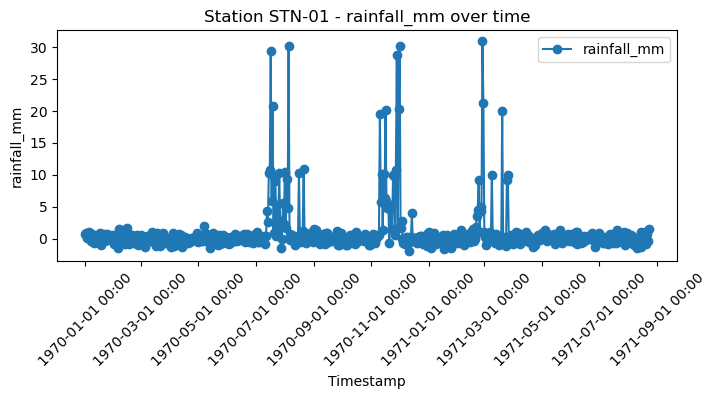

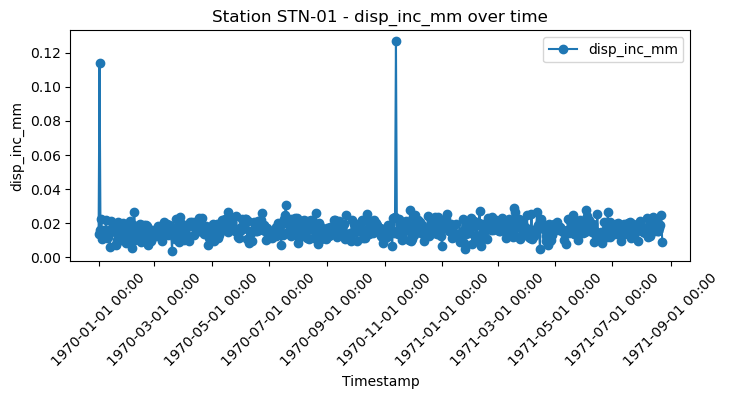

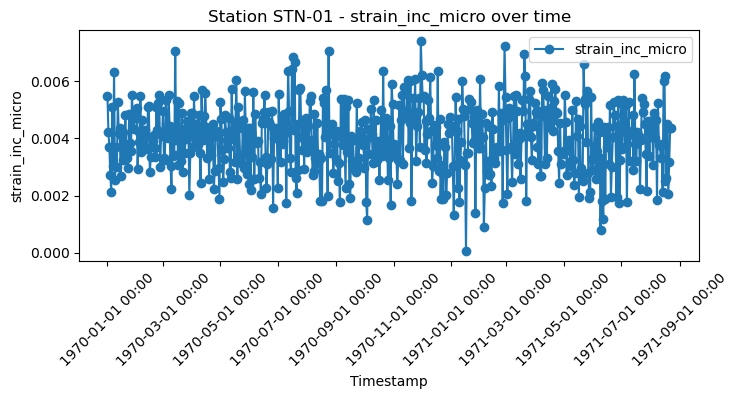

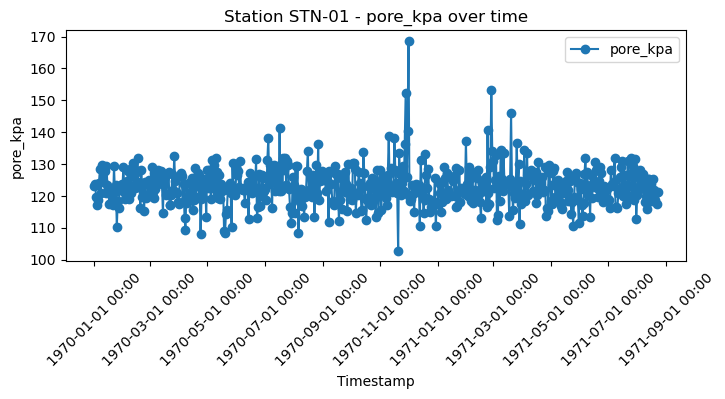

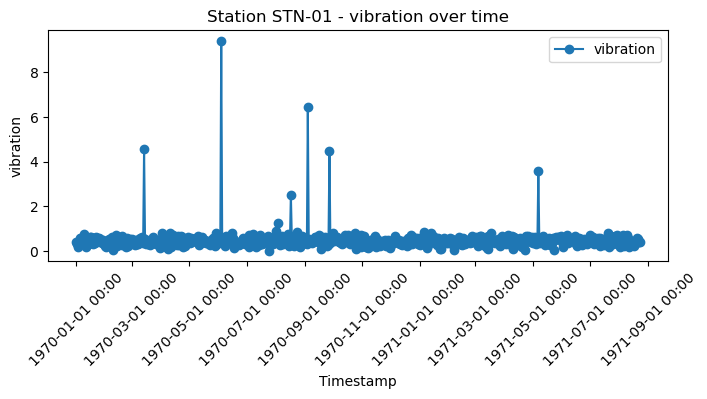

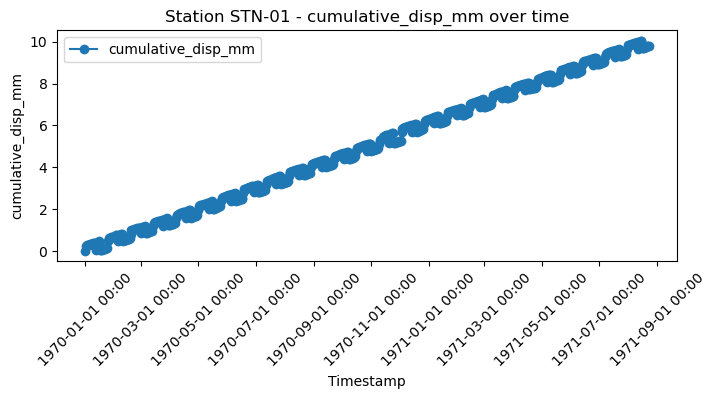


Station STN-01 → Zone: Bench-1, Lat: 34.02931, Lon: 74.820958, Elev: 1035m
 Latest Probability: 0.026
 Risk Status: LOW
----------------------------------------


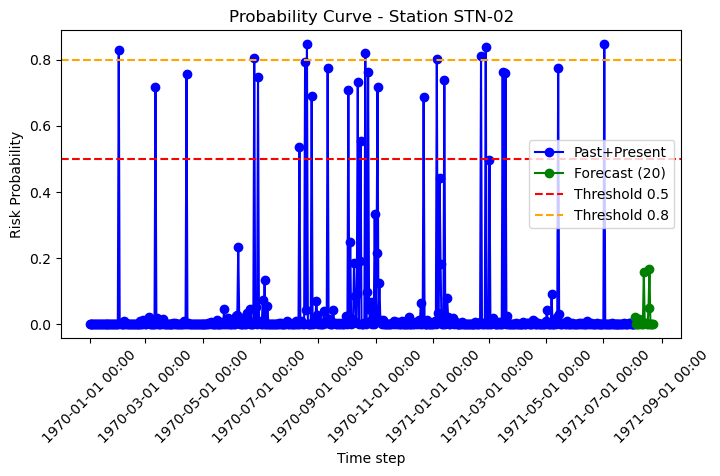

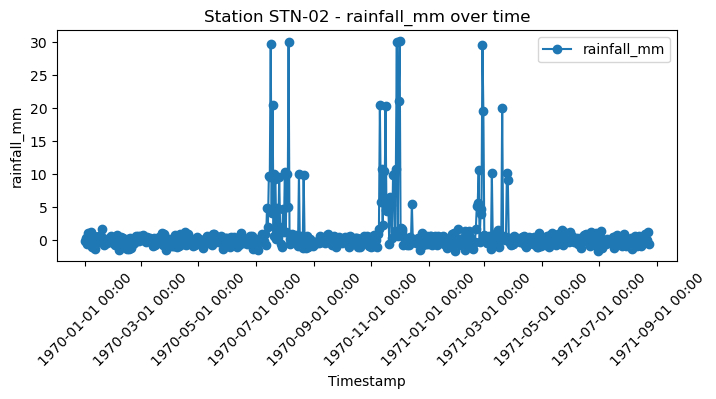

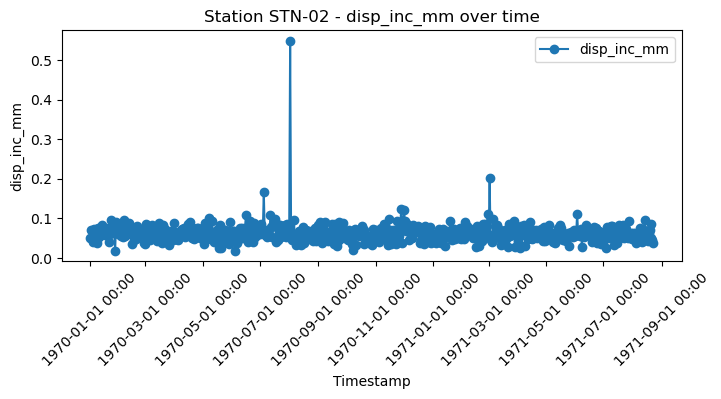

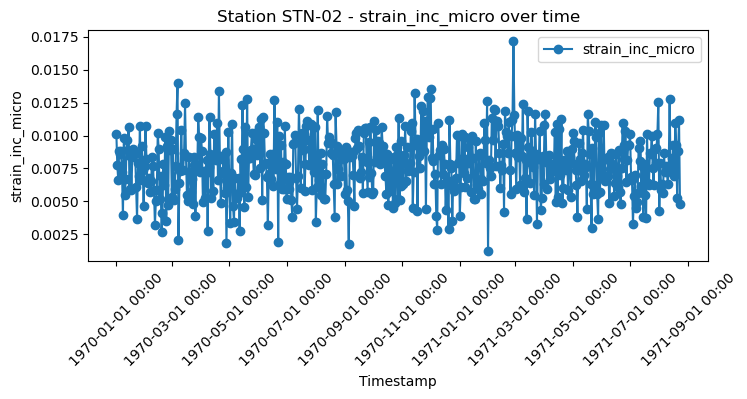

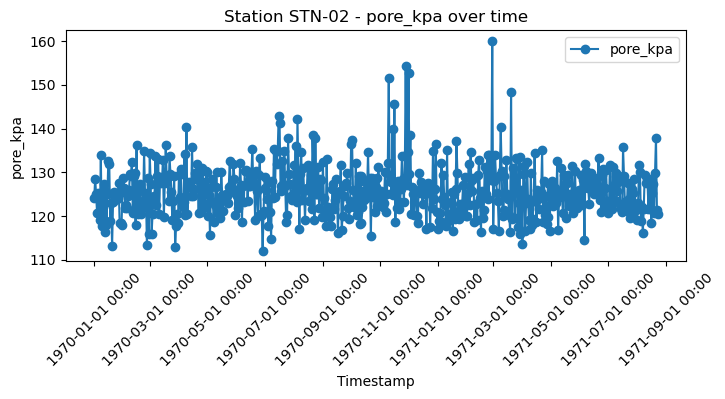

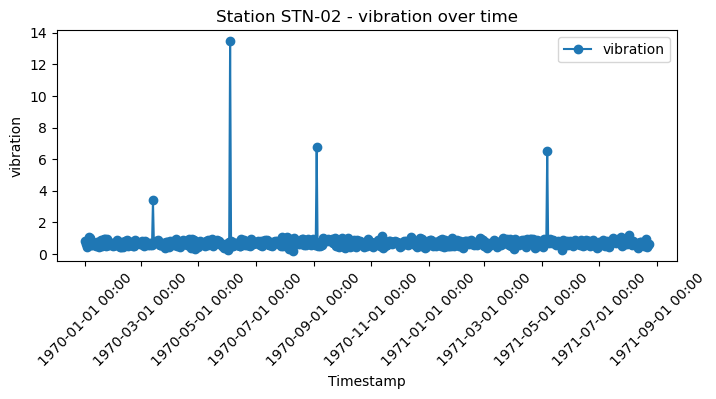

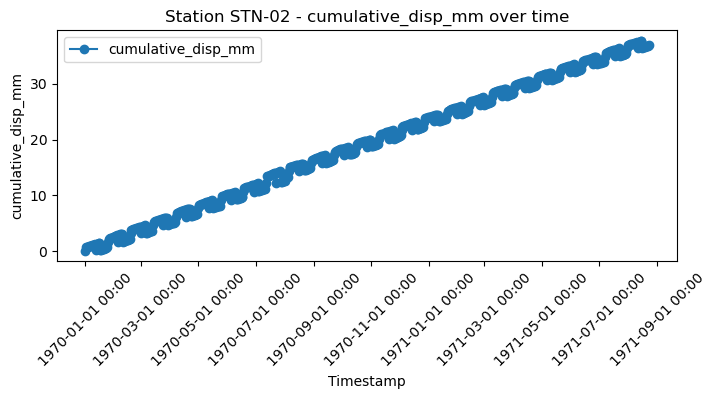


Station STN-02 → Zone: Bench-2, Lat: 34.04526, Lon: 74.798854, Elev: 1082m
 Latest Probability: 0.002
 Risk Status: LOW
----------------------------------------


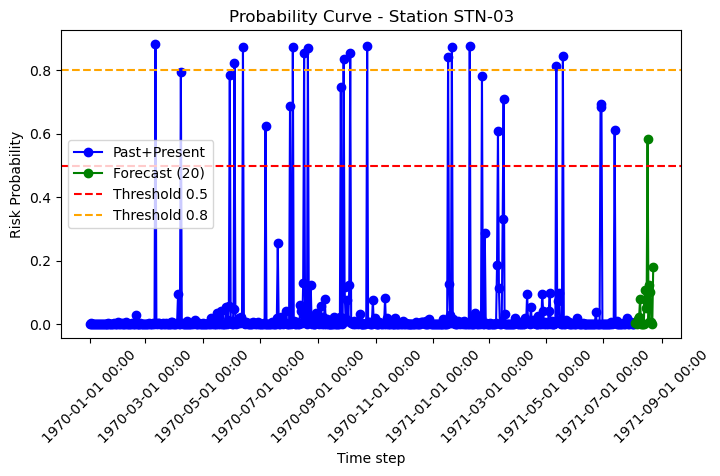

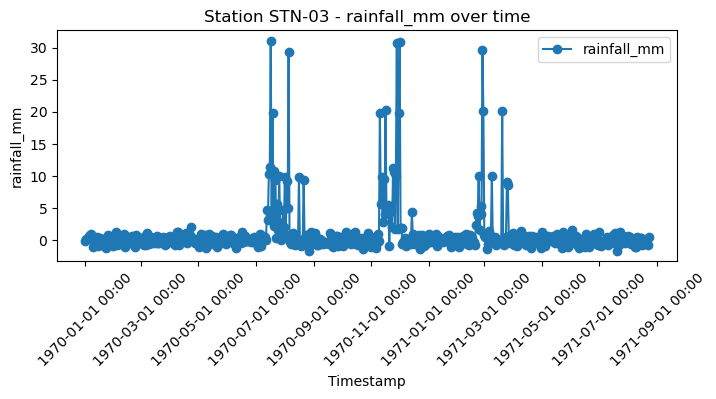

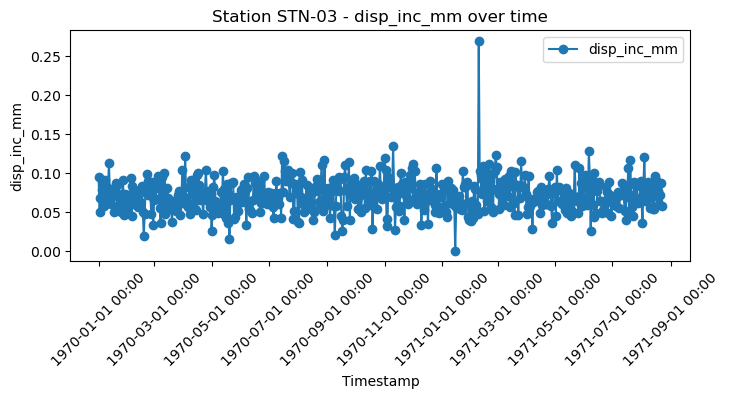

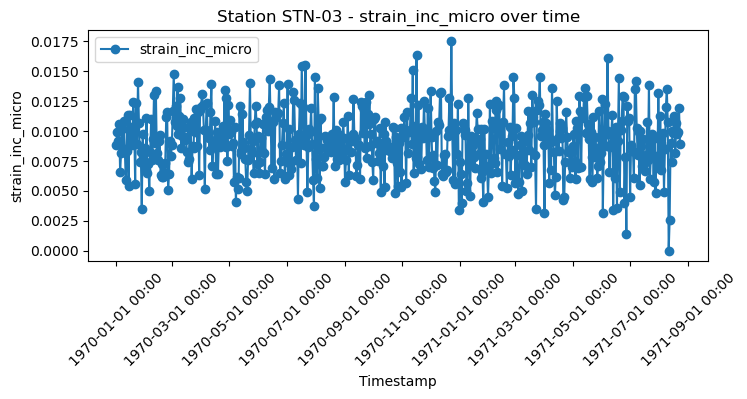

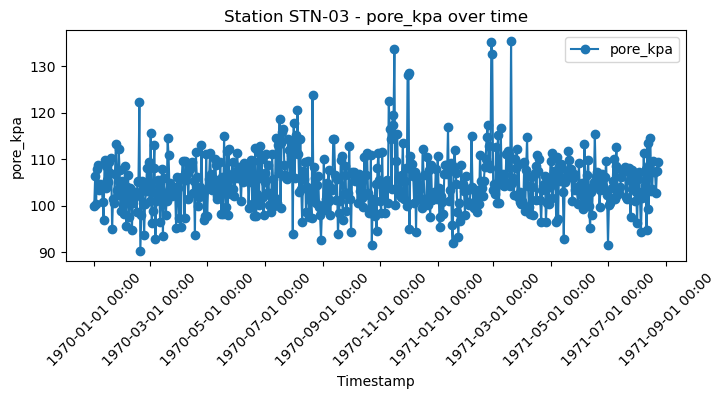

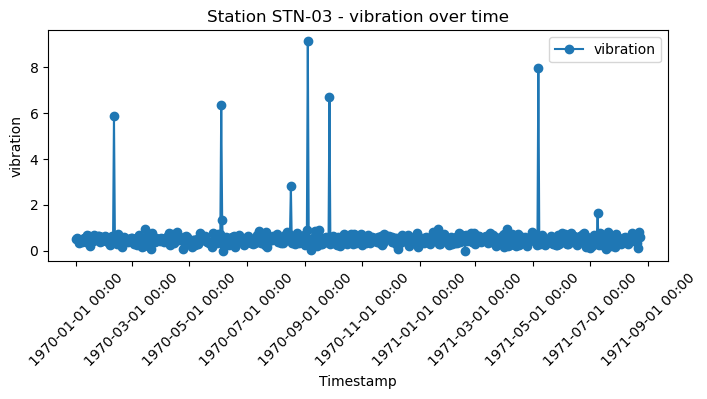

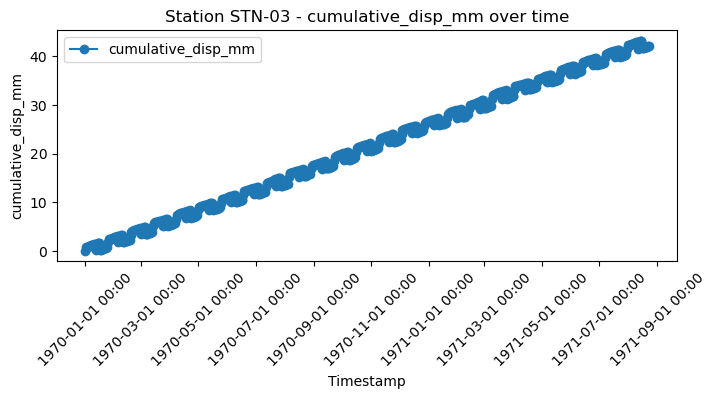


Station STN-03 → Zone: Bench-3, Lat: 34.078862, Lon: 74.796662, Elev: 1212m
 Latest Probability: 0.180
 Risk Status: LOW
----------------------------------------


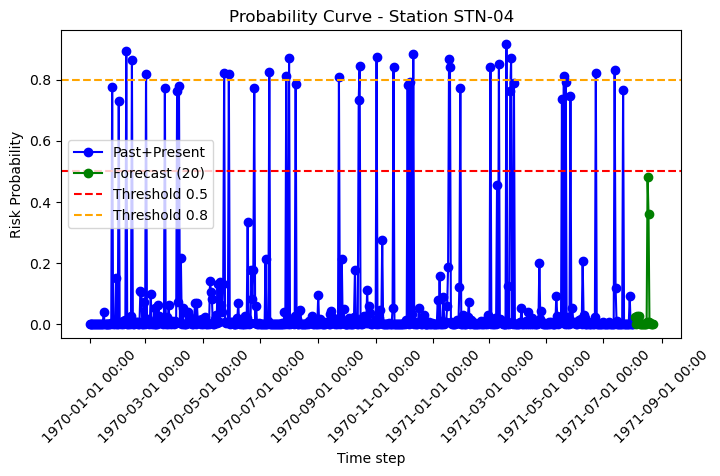

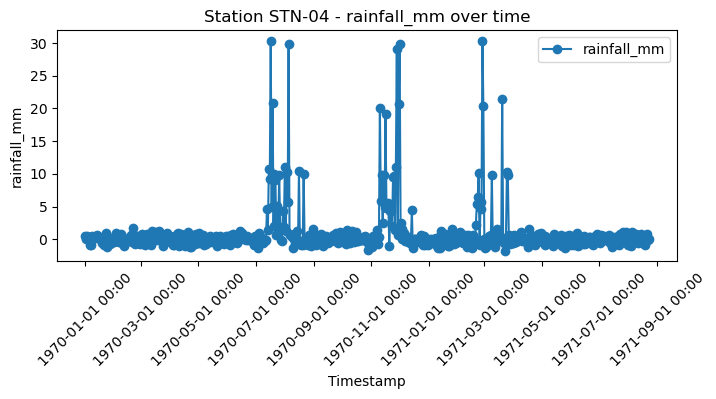

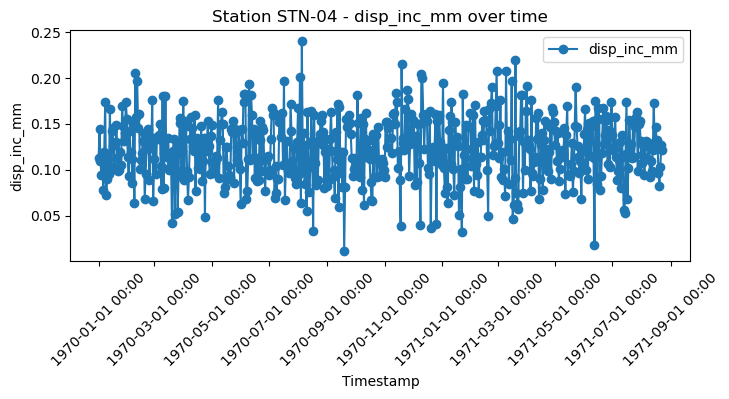

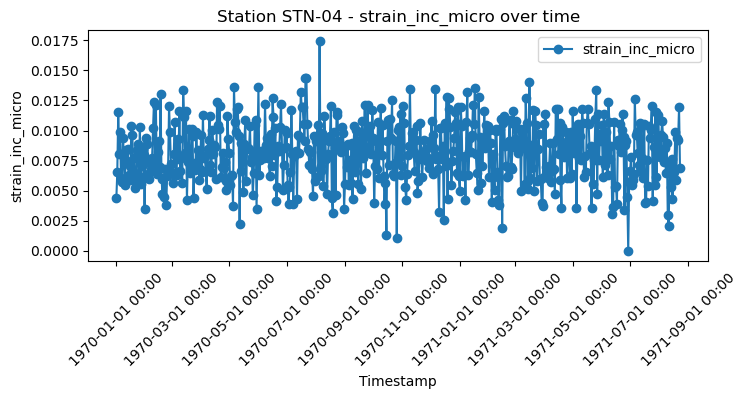

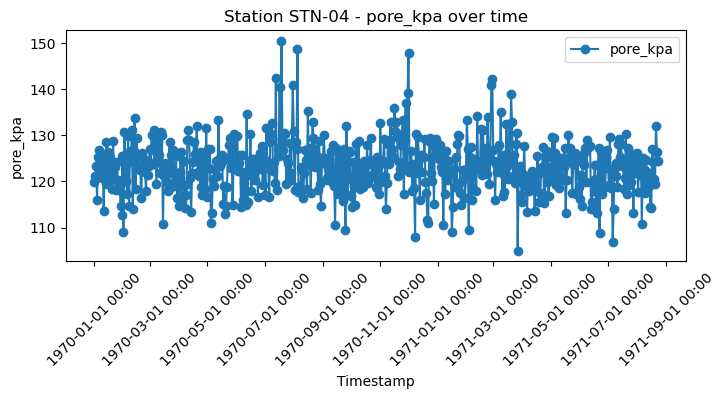

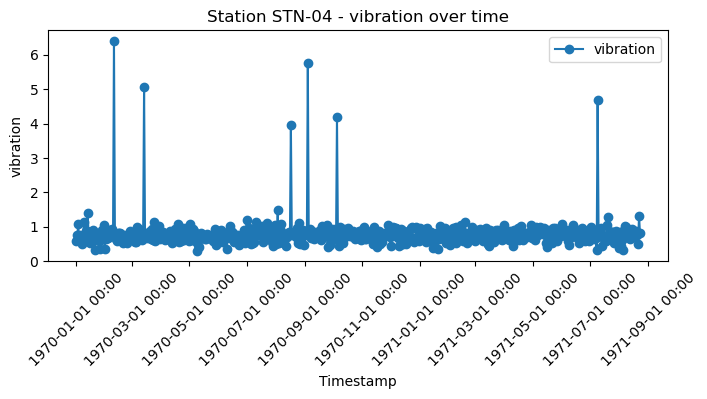

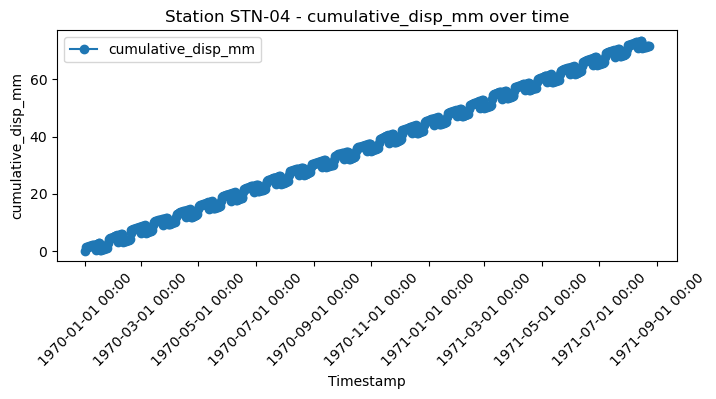


Station STN-04 → Zone: Bench-4, Lat: 34.041999, Lon: 74.806137, Elev: 1074m
 Latest Probability: 0.001
 Risk Status: LOW
----------------------------------------


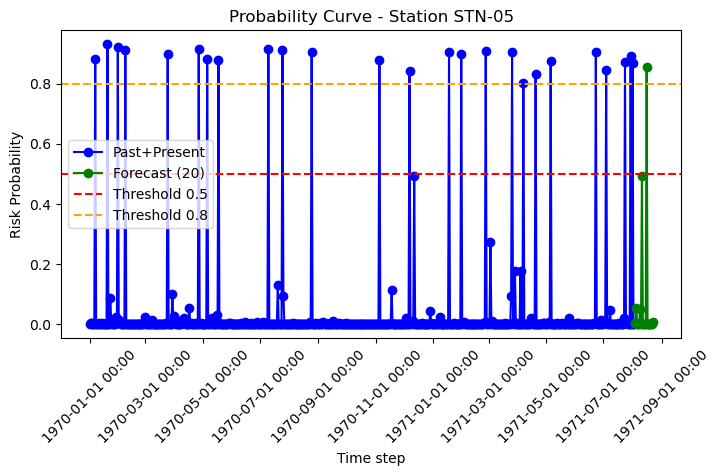

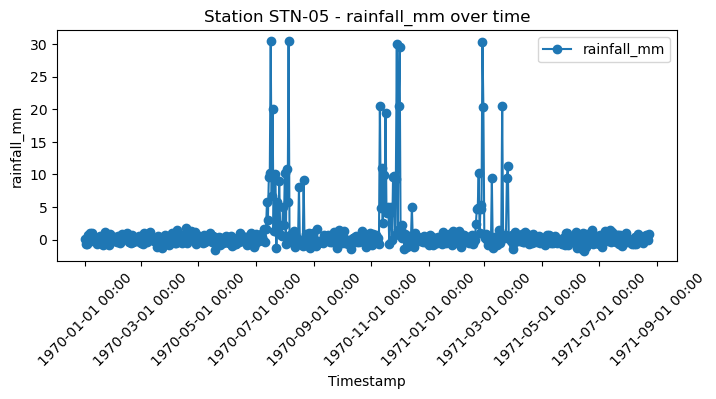

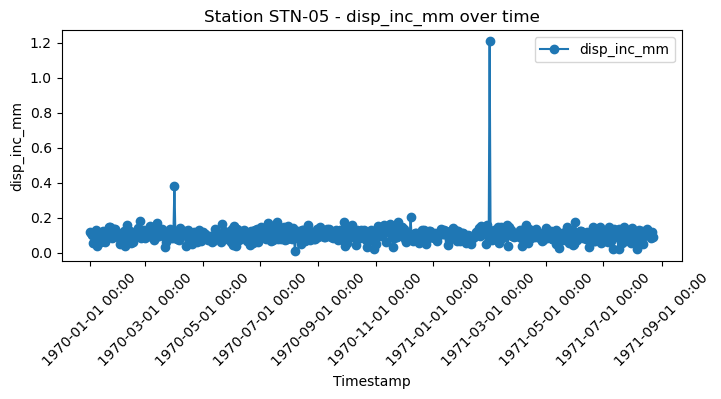

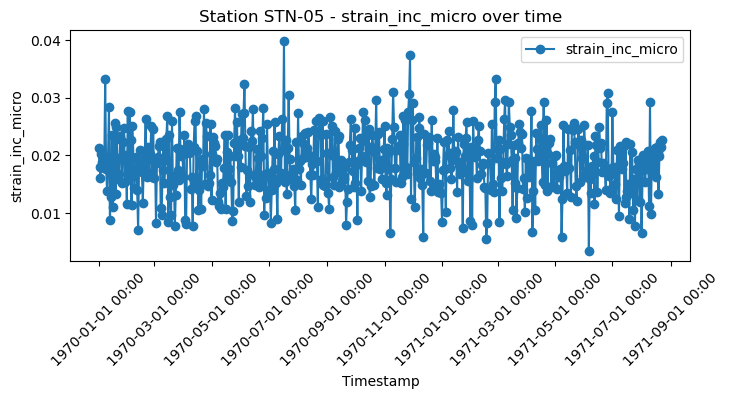

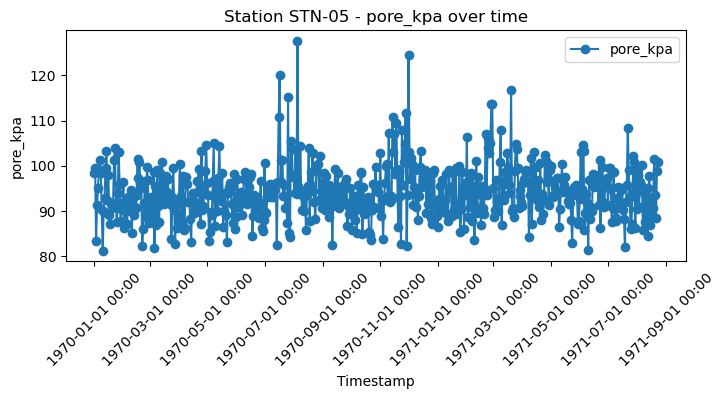

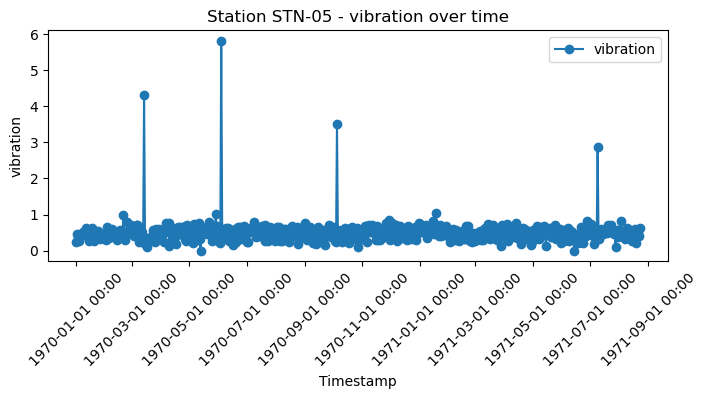

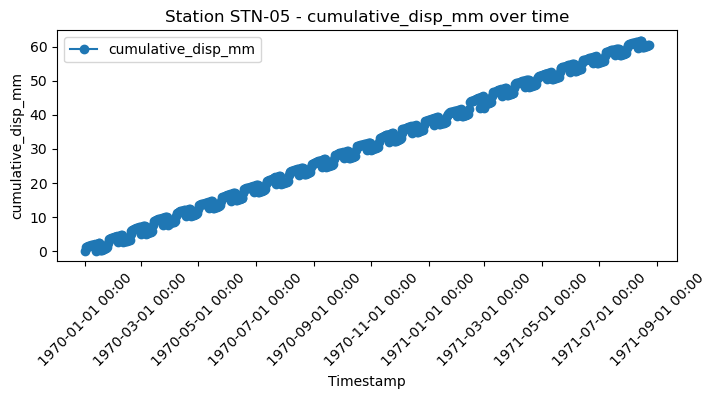


Station STN-05 → Zone: Bench-5, Lat: 34.022855, Lon: 74.810757, Elev: 783m
 Latest Probability: 0.009
 Risk Status: LOW
----------------------------------------


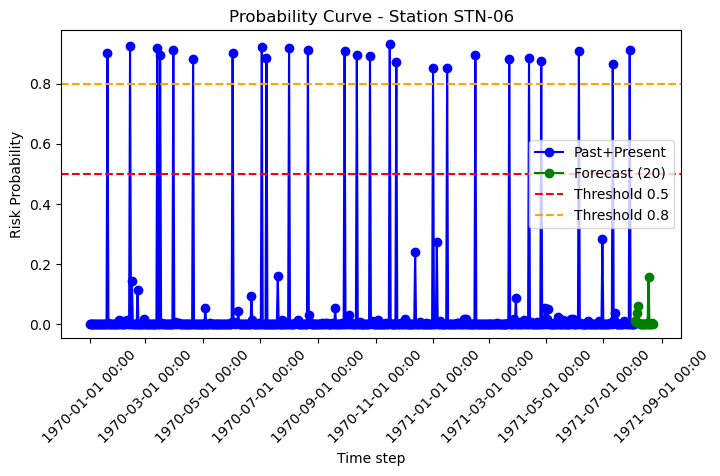

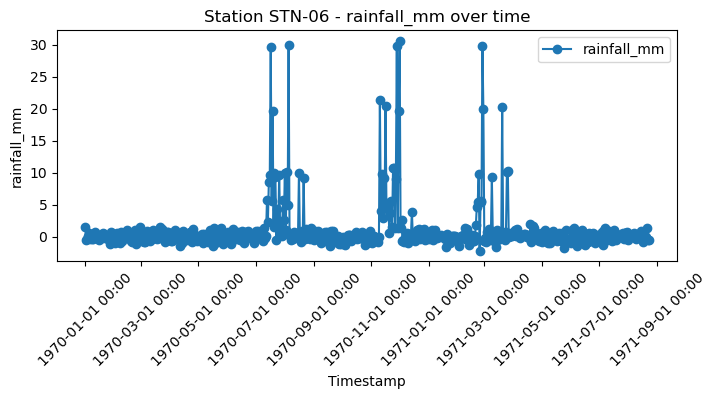

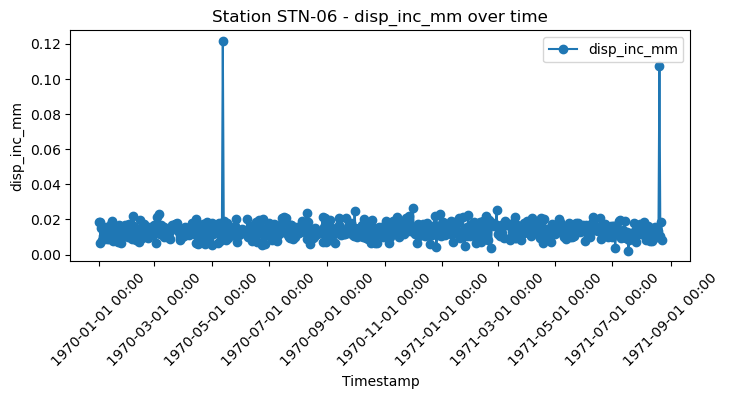

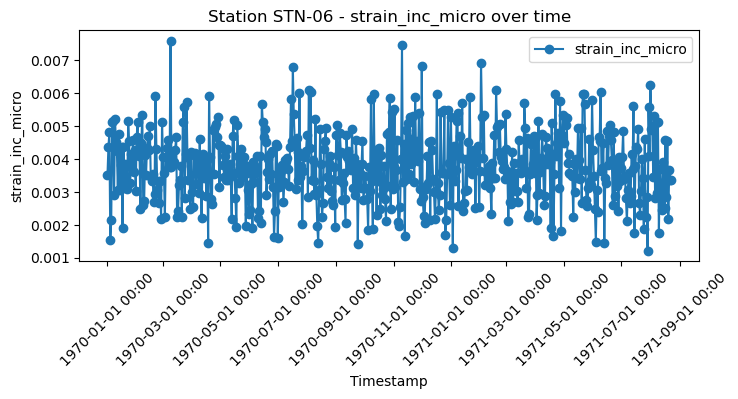

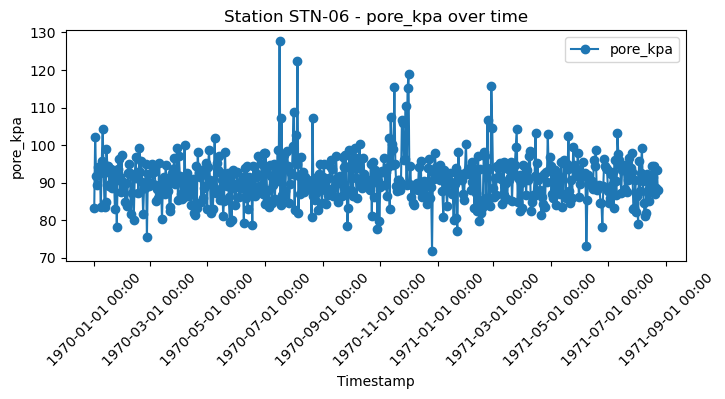

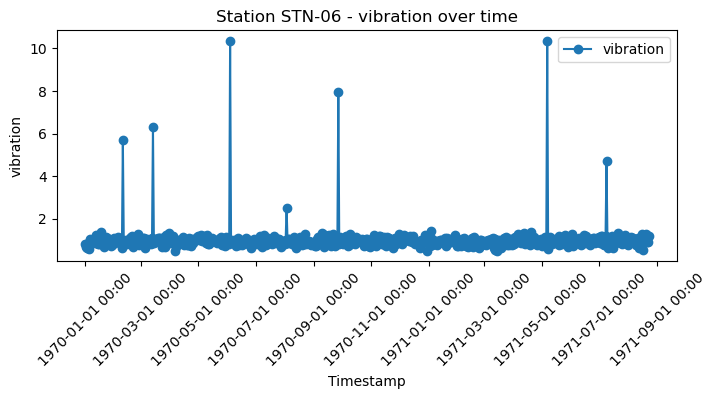

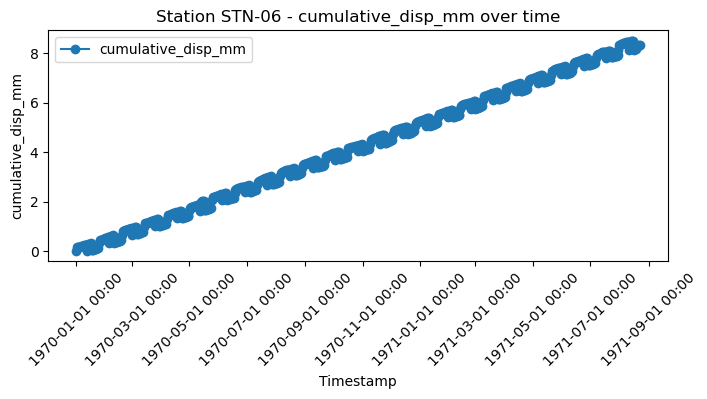


Station STN-06 → Zone: Bench-6, Lat: 34.053685, Lon: 74.805479, Elev: 795m
 Latest Probability: 0.002
 Risk Status: LOW
----------------------------------------


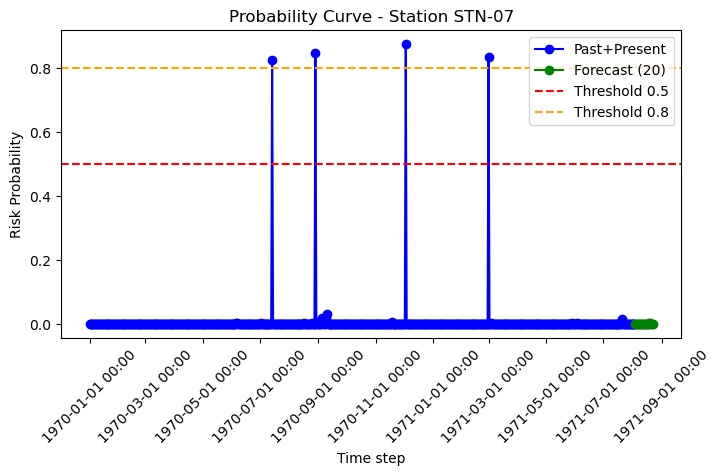

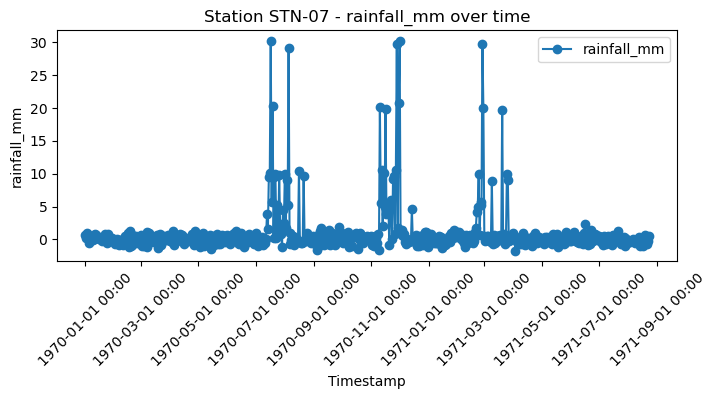

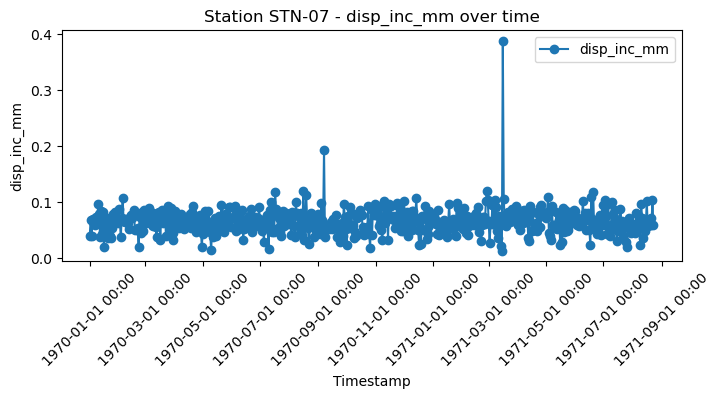

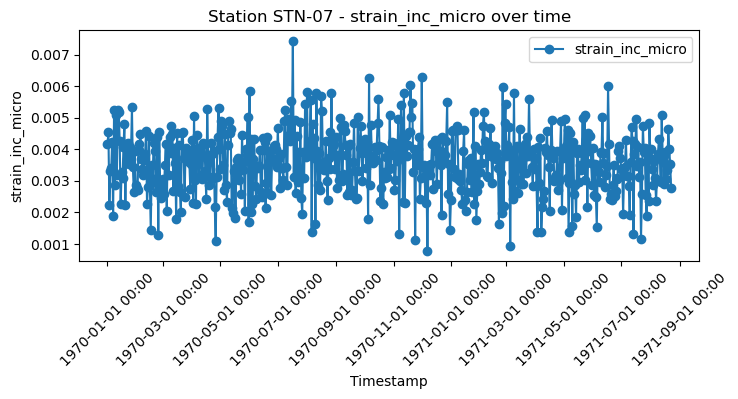

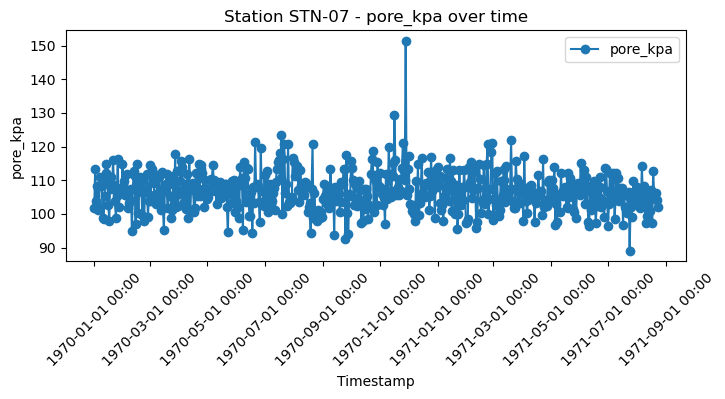

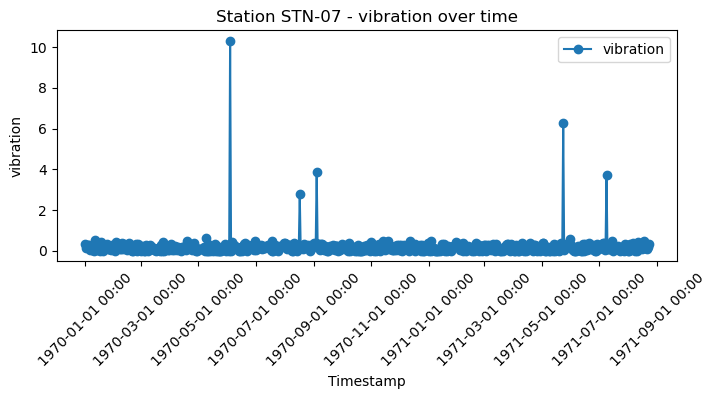

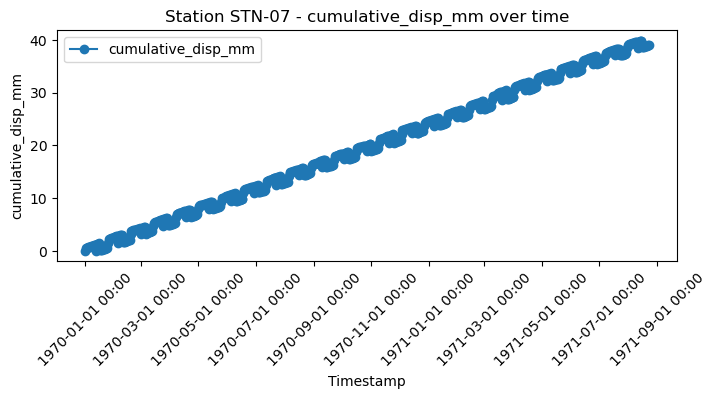


Station STN-07 → Zone: Bench-1, Lat: 34.0775, Lon: 74.771985, Elev: 1035m
 Latest Probability: 0.002
 Risk Status: LOW
----------------------------------------


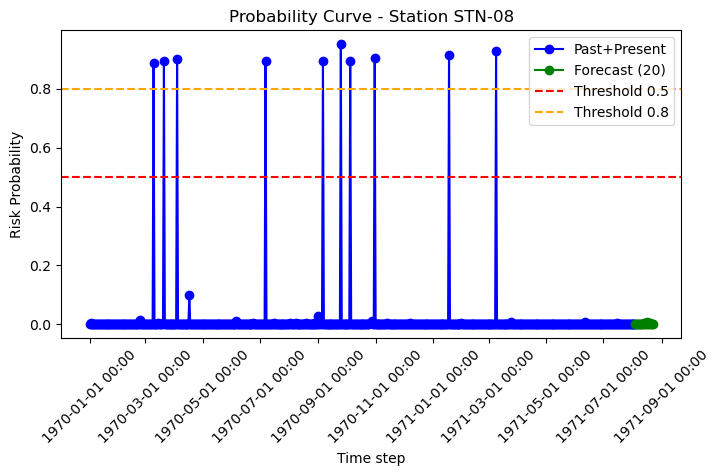

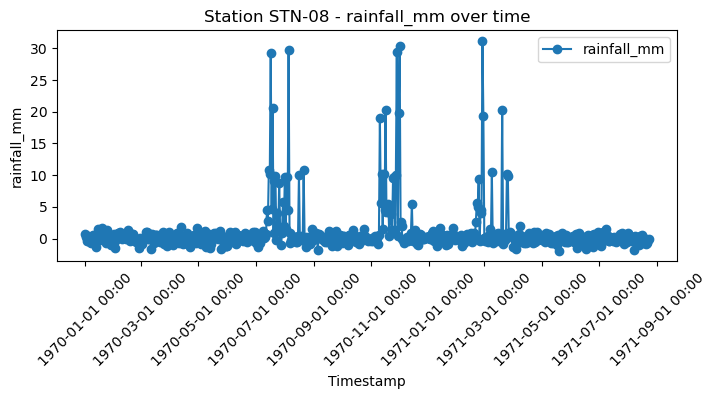

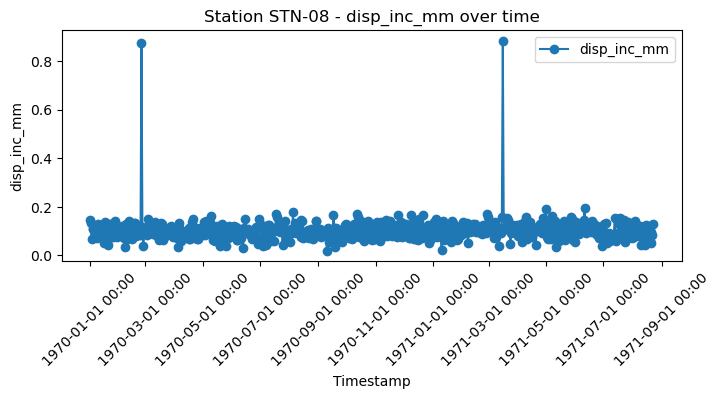

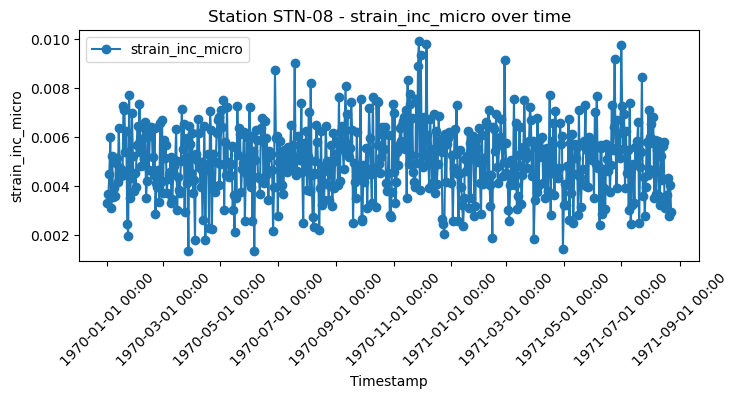

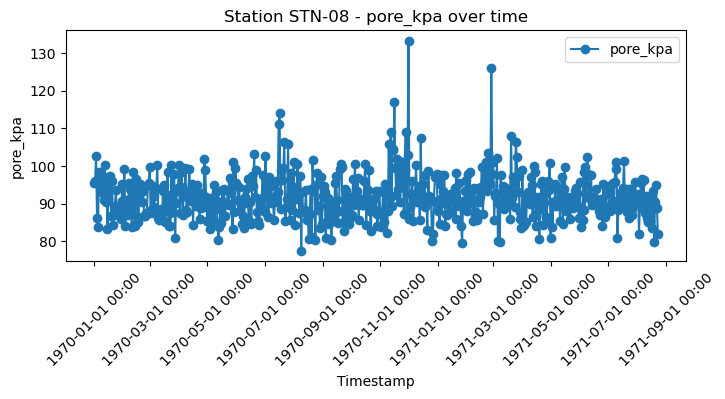

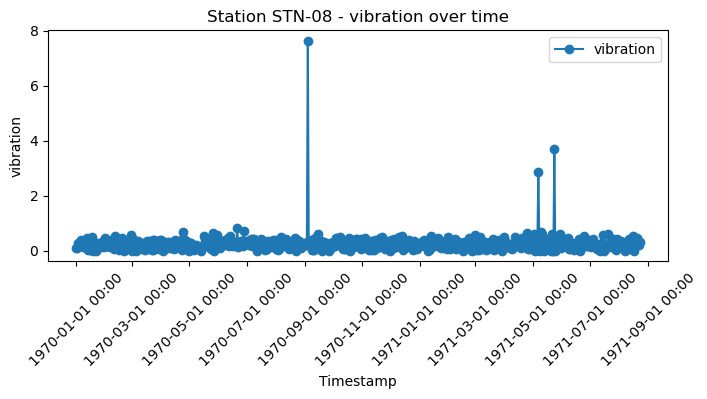

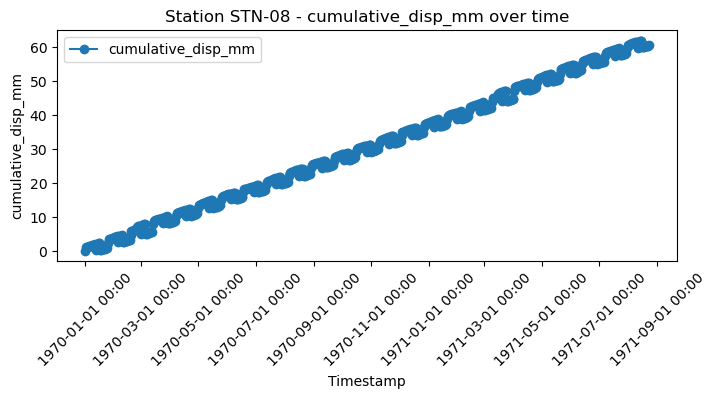


Station STN-08 → Zone: Bench-2, Lat: 34.060037, Lon: 74.773348, Elev: 788m
 Latest Probability: 0.002
 Risk Status: LOW
----------------------------------------


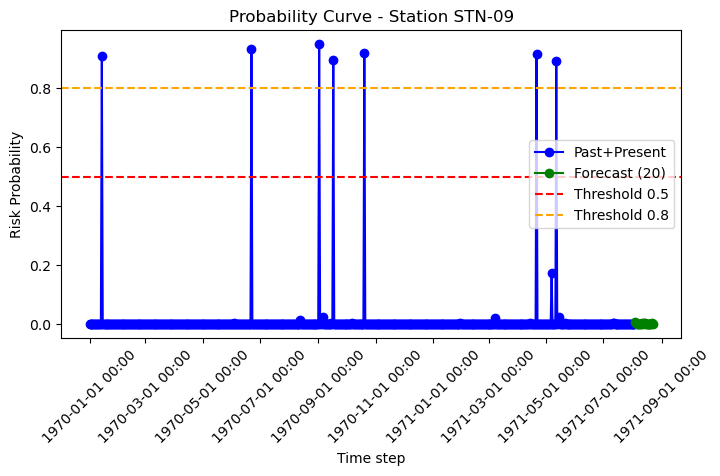

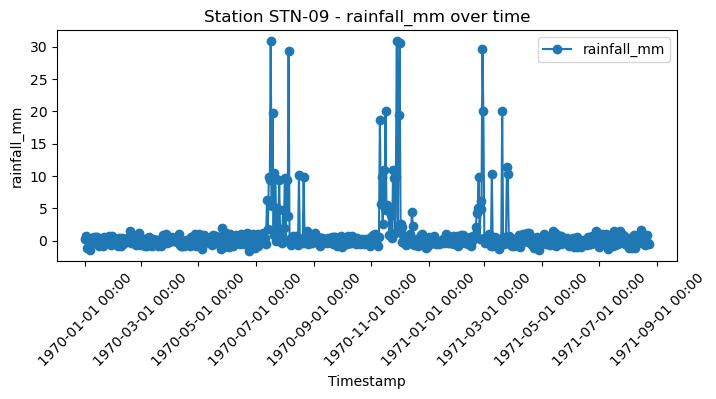

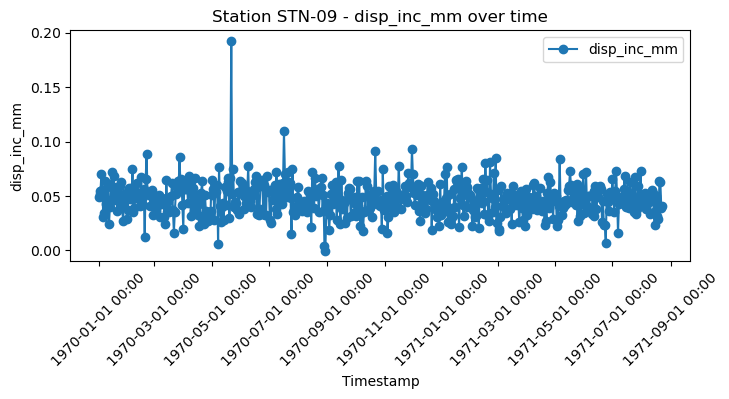

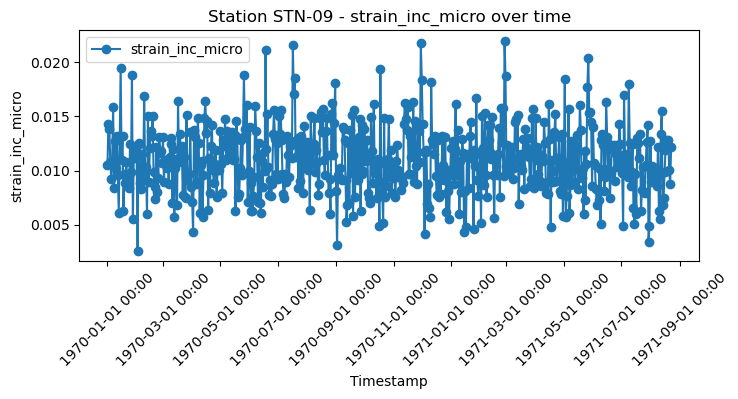

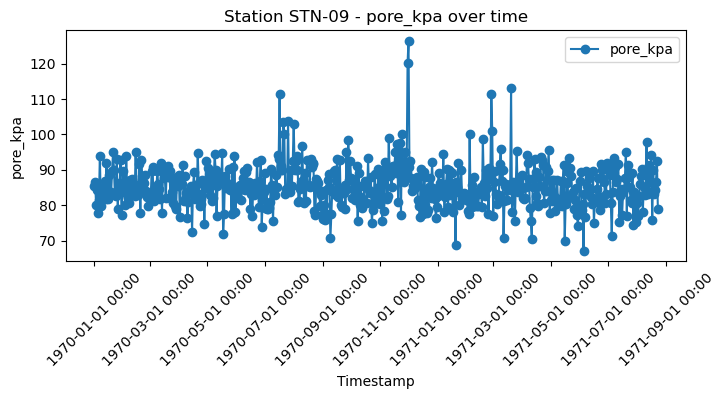

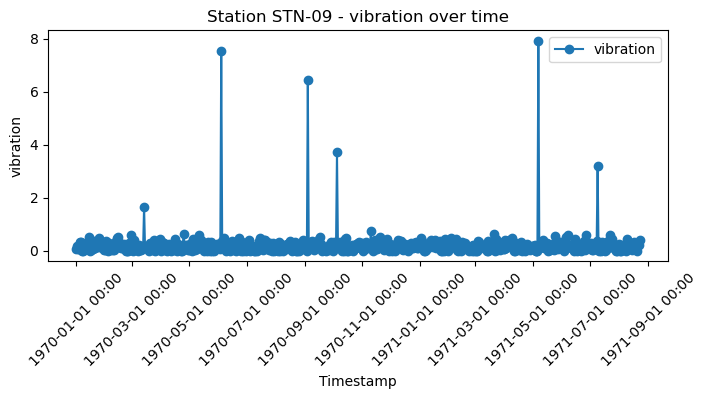

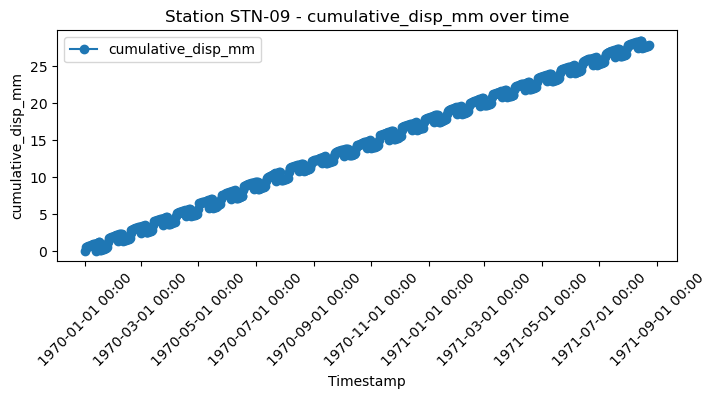


Station STN-09 → Zone: Bench-3, Lat: 34.028542, Lon: 74.817251, Elev: 1132m
 Latest Probability: 0.002
 Risk Status: LOW
----------------------------------------


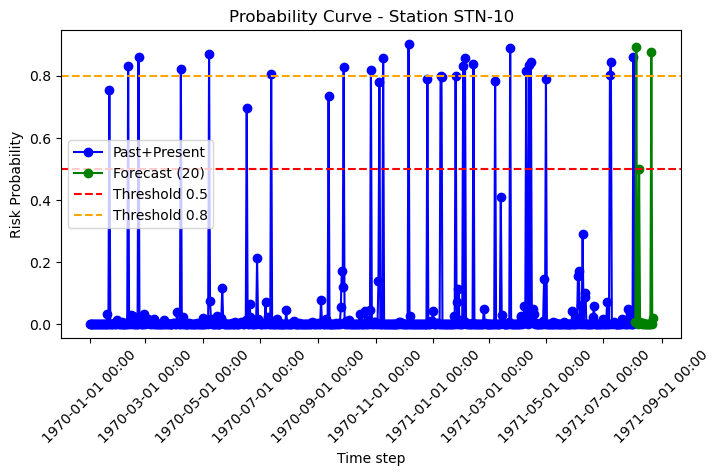

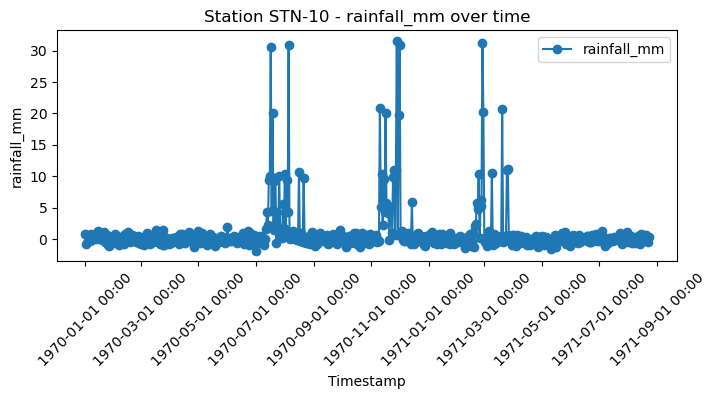

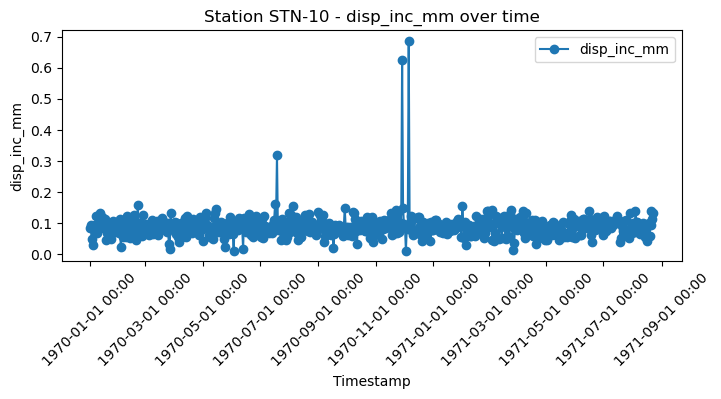

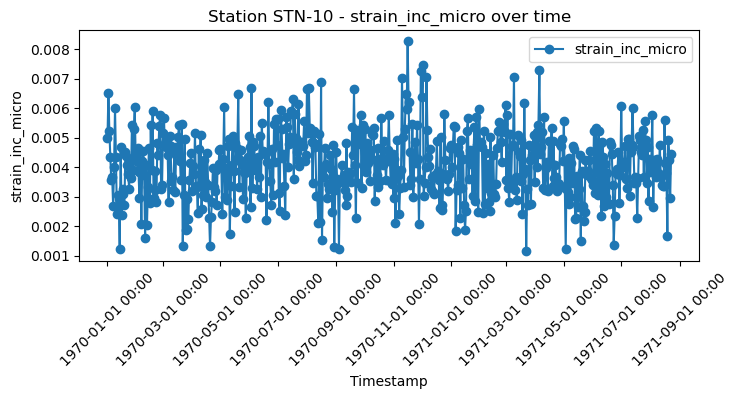

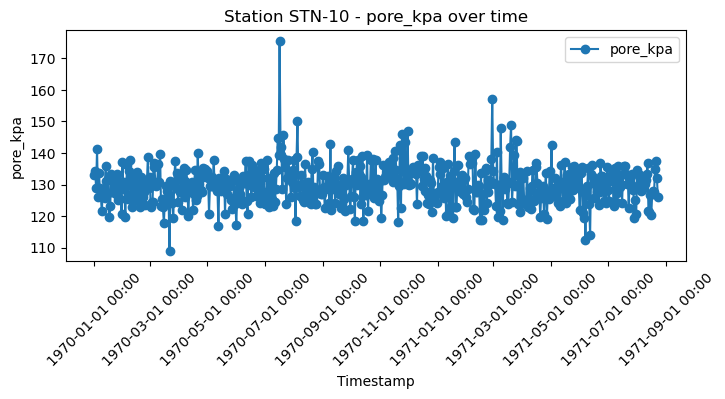

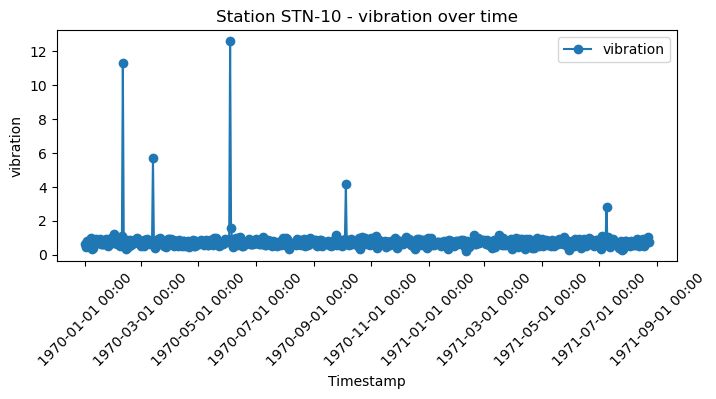

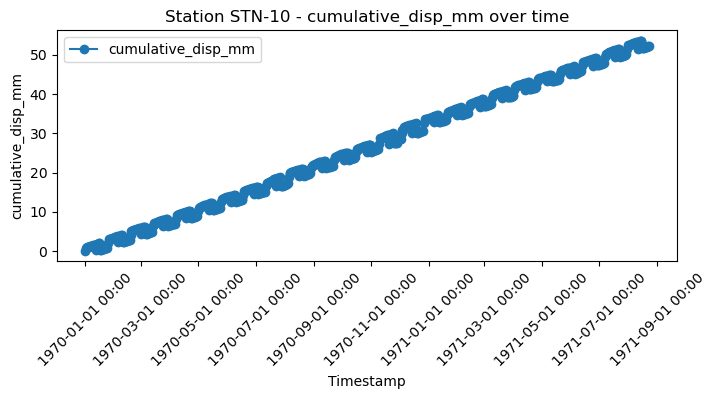


Station STN-10 → Zone: Bench-4, Lat: 34.056167, Lon: 74.808191, Elev: 1030m
 Latest Probability: 0.019
 Risk Status: LOW
----------------------------------------


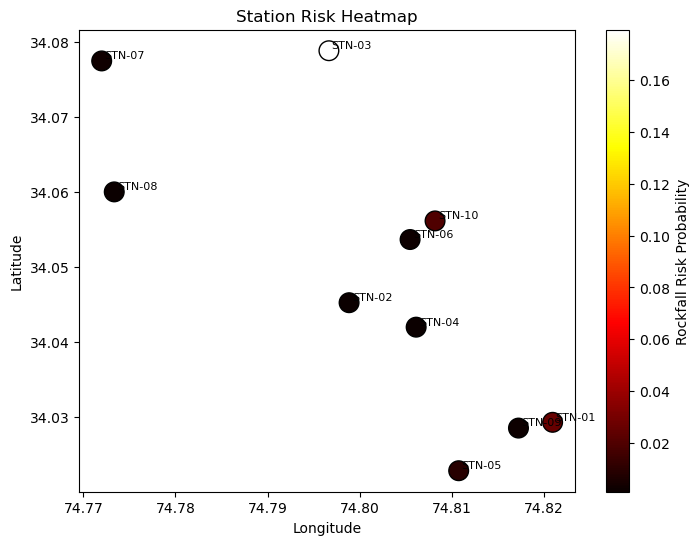

  station_id        lat        lon  probability risk
0     STN-01  34.029310  74.820958     0.025534  LOW
1     STN-02  34.045260  74.798854     0.001680  LOW
2     STN-03  34.078862  74.796662     0.179540  LOW
3     STN-04  34.041999  74.806137     0.001072  LOW
4     STN-05  34.022855  74.810757     0.009049  LOW
5     STN-06  34.053685  74.805479     0.002028  LOW
6     STN-07  34.077500  74.771985     0.002471  LOW
7     STN-08  34.060037  74.773348     0.001606  LOW
8     STN-09  34.028542  74.817251     0.001885  LOW
9     STN-10  34.056167  74.808191     0.019395  LOW


In [57]:
def inference():
    # 1) Load dataset
    tab_df = pd.read_csv("simulated_mine_6000_realistic_unbiased.csv")

    # 2) Train LightGBM baseline and split data
    lgb_model, train_df, forecast_df = train_lightgbm(tab_df)

    # 3) Prepare sequences and train Transformer (only training portion)
    X_seq, y_seq= prepare_sequences(train_df)
    transformer = train_transformer(X_seq, y_seq, epochs=6)

    # 4) Build fusion datasets
    X_fuse_train, y_train = build_fusion_dataset(train_df, transformer, lgb_model)
    meta = train_fusion_model(X_fuse_train, y_train)

    # Forecast fusion dataset
    X_fuse_forecast, _ = build_fusion_dataset(forecast_df, transformer, lgb_model)

   # print("[RUN] Running inference...")
    station_results = []
    # ---- Inference per station ----
    for sid in tab_df['station_id'].unique():
        train_mask = train_df["station_id"] == sid
        forecast_mask = forecast_df["station_id"] == sid

        # Past+present
        probs_train = meta.predict_proba(X_fuse_train[train_mask])[:, 1]
        # Forecast
        probs_forecast = meta.predict_proba(X_fuse_forecast[forecast_mask])[:, 1] if forecast_mask.any() else []

        # Latest probability (from forecast if exists, else train)
        latest_prob = probs_forecast[-1] if len(probs_forecast) > 0 else probs_train[-1]
     

        # Risk categorization
        if latest_prob < 0.5:
            risk_status = "LOW"
        elif latest_prob <= 0.8:
            risk_status = "MEDIUM"
        else:
            risk_status = "HIGH"

        g = tab_df[tab_df["station_id"] == sid]

        # ---- Plot ----
        import matplotlib.pyplot as plt
        import matplotlib.dates as mdates
        plt.figure(figsize=(8, 4))
        plt.plot(range(len(probs_train)), probs_train, marker='o', color='blue', label='Past+Present')
        if len(probs_forecast) > 0:
            plt.plot(range(len(probs_train), len(probs_train) + len(probs_forecast)),
                     probs_forecast, marker='o', color='green', label='Forecast (20)')
        plt.axhline(0.5, color='r', linestyle='--', label='Threshold 0.5')
        plt.axhline(0.8, color='orange', linestyle='--', label='Threshold 0.8')
        plt.xlabel("Time step")
        plt.ylabel("Risk Probability")
        plt.title(f"Probability Curve - Station {sid}")
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.xticks(rotation=45)  # rotate labels so they don’t overlap
        plt.show()
        


        sensor_cols = ["rainfall_mm", "disp_inc_mm", "strain_inc_micro", 
                       "pore_kpa", "vibration", "cumulative_disp_mm"]
        #sensors.
        g_sorted = g.sort_values("timestamp")  # ensure time order
        for sensor in sensor_cols:
            plt.figure(figsize=(8, 3))
            plt.plot(g_sorted["timestamp"], g_sorted[sensor], marker='o', label=sensor)
            plt.xlabel("Timestamp")
            plt.ylabel(sensor)
            plt.title(f"Station {sid} - {sensor} over time")
            plt.legend()
            # Format x-axis as dates/times
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.xticks(rotation=45)  # rotate labels so they don’t overlap
            plt.show()

        
        # Metadata
        g = tab_df[tab_df["station_id"] == sid]
        la, lon, elev, zone = g['lat'].iloc[0], g['lon'].iloc[0], g['elevation_m'].iloc[0], g['zone'].iloc[0]
        print(f"\nStation {sid} → Zone: {zone}, Lat: {la}, Lon: {lon}, Elev: {elev}m")
        print(f" Latest Probability: {latest_prob:.3f}")
        print(f" Risk Status: {risk_status}")
        print("-"*40)
        la = g['lat'].iloc[0]
        lon = g['lon'].iloc[0]

        # Collect for heatmap
        station_results.append([sid, la, lon, latest_prob, risk_status])

        # ---- Create heatmap ----
        results_df = pd.DataFrame(station_results, columns=["station_id", "lat", "lon", "probability", "risk"])
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(results_df["lon"], results_df["lat"], 
                     c=results_df["probability"], cmap="hot", s=200, edgecolor="k")
    plt.colorbar(sc, label="Rockfall Risk Probability")
    plt.title("Station Risk Heatmap")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    for _, row in results_df.iterrows():
        plt.text(row["lon"] + 0.0003, row["lat"] + 0.0003, row["station_id"], fontsize=8)

    plt.show()
    



    # ---- Folium Heatmap ----
    # Center map on average lat/lon
    center_lat, center_lon = results_df["lat"].mean(), results_df["lon"].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

    # Adding heatmap layer (weighted by probability)
    heat_data = results_df[['lat', 'lon', 'probability']].values.tolist()
    HeatMap(heat_data, min_opacity=0.4, max_zoom=12, radius=25, blur=15).add_to(m)

    # Add markers for each station with popup info
    for _, row in results_df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=6,
            color="black",
            weight=1,
            fill=True,
            fill_color="red" if row["risk"]=="HIGH" else "orange" if row["risk"]=="MEDIUM" else "green",
            fill_opacity=0.8,
            popup=folium.Popup(
                f"Station {row['station_id']}<br>"
                f"Probability: {row['probability']:.3f}<br>"
                f"Risk: {row['risk']}",
                max_width=200
            )
        ).add_to(m)

    # Save interactive map to HTML
    m.save("rockfall_risk_heatmap.html")
    # print(" Heatmap saved to rockfall_risk_heatmap.html (open in browser)")

    print (results_df)
    print(m)

    # print(results_df)
if __name__ == '__main__':
    inference()
    


In [62]:
import webbrowser

webbrowser.open("rockfall_risk_heatmap.html")


True